<h1 id="tocheading">Attrition Demo</h1>
<div id="toc"></div>

<img src="https://github.com/elenalowery/DSX_Local_Workshop/blob/master/img/CC_Intro.JPG?raw=true" width="800" height="500" align="middle"/>

The Attrition demo focuses on retaining Merchants that are using company network for credit card processing. Here is the description of the case:

A client approved many low value merchant accounts without much scrutiny.  Many of those merchant accounts resulted in default. The client thinks that they should have put more of an emphasis on their applicant screening process. IBM suggests to enable fact based decision making for performance of its joint marketing programs.

This notebook will demostrate how to

1. Use Brunel and Seaborn library for visualizations

2. Use regular python Machine Learning libary scikit-learn and Spark's Machine Learning library(MLlib) for predicitive modeling in an intergrated environment on DSX.
3. Deploy SparkML model using Machine Learning Service

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Load Libraries

Run the following cell to import required libraries.

In [2]:
import sklearn
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import pandas as pd
pd.options.display.max_columns = 999

import brunel

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency,ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score

import numpy as np

import urllib3, requests, json

## Load Customer History Data

In [4]:
import os
from pyspark.sql import SQLContext
# Add asset from file system
cust_spark = SQLContext(sc).read.csv(os.environ['DSX_PROJECT_DIR']+'/datasets/CUST_HISTORY.csv', header='true', inferSchema = 'true')
cust_spark.show(5)

+--------+-----------------+-----------------------+--------------------+--------------+------------+---------------+----------+-----+--------+----------+------------------+------------+---------+----------------+---------------+---------+-----------------+------------------+----+-------------+--------------+---------+--------+---------+------------------+----------+
|MERCHANT|ACCT_STATUS_K_USD|CONTRACT_DURATION_MONTH|             HISTORY|CREDIT_PROGRAM|AMOUNT_K_USD|   ACCOUNT_TYPE|  ACCT_AGE|STATE|IS_URBAN|IS_XBORDER|SELF_REPORTED_ASMT|CO_APPLICANT|GUARANTOR|PRESENT_RESIDENT|OWN_REAL_ESTATE|PROP_UNKN|ESTABLISHED_MONTH|OTHER_INSTALL_PLAN|RENT|OWN_RESIDENCE|NUMBER_CREDITS|RFM_SCORE|BRANCHES|TELEPHONE|SHIP_INTERNATIONAL|IS_DEFAULT|
+--------+-----------------+-----------------------+--------------------+--------------+------------+---------------+----------+-----+--------+----------+------------------+------------+---------+----------------+---------------+---------+-----------------+---

Create a Pandas DataFrame from the Spark DataFrame.  A Pandas DataFrame is required for the analysis below

In [5]:
cust_pd=cust_spark.toPandas()
cust_pd.head()

MERCHANT ACCT_STATUS_K_USD  CONTRACT_DURATION_MONTH  \
0       893             0 USD                       12   
1       894      0 to 200 USD                       36   
2       895              NONE                       18   
3       896              NONE                       36   
4       897             0 USD                       21   

                      HISTORY CREDIT_PROGRAM  AMOUNT_K_USD     ACCOUNT_TYPE  \
0            CRITICAL ACCOUNT        NEW CAR          2171  up to 100 K USD   
1            CRITICAL ACCOUNT       USED CAR          5800  up to 100 K USD   
2            CRITICAL ACCOUNT    ELECTRONICS          1169     UNKNOWN/NONE   
3               DELAY IN PAST       USED CAR          8947     UNKNOWN/NONE   
4  EXISTING CREDITS PAID BACK    ELECTRONICS          2606  up to 100 K USD   

     ACCT_AGE STATE IS_URBAN IS_XBORDER SELF_REPORTED_ASMT CO_APPLICANT  \
0  1 to 4 YRS    NY       NO        YES                 NO           NO   
1  1 to 4 YRS    CT       NO        YES                 NO           NO   
2  1 to 4 YRS    NY       NO        YES                 NO           NO   
3  4 to 7 YRS    CT       NO        YES                 NO           NO   
4  up to 1 YR    NY       NO         NO                 NO           NO   

  GUARANTOR PRESENT_RESIDENT OWN_REAL_ESTATE PROP_UNKN  ESTABLISHED_MONTH  \
0        NO                4              NO        NO                 38   
1        NO                4              NO        NO                 34   
2        NO      above 4 YRS              NO        NO                 29   
3        NO       2 to 3 YRS              NO        NO                 31   
4        NO                4              NO        NO                 28   

  OTHER_INSTALL_PLAN RENT OWN_RESIDENCE  NUMBER_CREDITS  RFM_SCORE  BRANCHES  \
0                YES   NO           YES               2          2         1   
1                 NO   NO           YES               2          3         1   
2                 NO   NO           YES               2          3         1   
3                YES   NO           YES               1          4         2   
4                 NO  YES            NO               1          4         1   

  TELEPHONE SHIP_INTERNATIONAL IS_DEFAULT  
0        NO                YES         No  
1       YES                 NO         No  
2       YES                 NO         No  
3       YES                 NO         No  
4       YES                 NO         No

### Dataset Overview

Let's take a quick look at the dataset.

In [6]:
print "There are " + str(len(cust_pd)) + " observations in the customer history dataset."
print "There are " + str(len(cust_pd.columns)) + " variables in the dataset."

print "\n******************Descriptive statistics*****************************\n"
print cust_pd.describe()

print "\n******************Dataset Quick View*****************************\n"
cust_pd.head()

There are 1000 observations in the customer history dataset.
There are 27 variables in the dataset.

******************Descriptive statistics*****************************

          MERCHANT  CONTRACT_DURATION_MONTH  AMOUNT_K_USD  ESTABLISHED_MONTH  \
count  1000.000000              1000.000000   1000.000000        1000.000000   
mean    500.500000                20.903000   3271.258000          35.546000   
std     288.819436                12.058814   2822.736876          11.375469   
min       1.000000                 4.000000    250.000000          19.000000   
25%     250.750000                12.000000   1365.500000          27.000000   
50%     500.500000                18.000000   2319.500000          33.000000   
75%     750.250000                24.000000   3972.250000          42.000000   
max    1000.000000                72.000000  18424.000000          75.000000   

       NUMBER_CREDITS    RFM_SCORE     BRANCHES  
count     1000.000000  1000.000000  1000.000000  
mean   

MERCHANT ACCT_STATUS_K_USD  CONTRACT_DURATION_MONTH  \
0       893             0 USD                       12   
1       894      0 to 200 USD                       36   
2       895              NONE                       18   
3       896              NONE                       36   
4       897             0 USD                       21   

                      HISTORY CREDIT_PROGRAM  AMOUNT_K_USD     ACCOUNT_TYPE  \
0            CRITICAL ACCOUNT        NEW CAR          2171  up to 100 K USD   
1            CRITICAL ACCOUNT       USED CAR          5800  up to 100 K USD   
2            CRITICAL ACCOUNT    ELECTRONICS          1169     UNKNOWN/NONE   
3               DELAY IN PAST       USED CAR          8947     UNKNOWN/NONE   
4  EXISTING CREDITS PAID BACK    ELECTRONICS          2606  up to 100 K USD   

     ACCT_AGE STATE IS_URBAN IS_XBORDER SELF_REPORTED_ASMT CO_APPLICANT  \
0  1 to 4 YRS    NY       NO        YES                 NO           NO   
1  1 to 4 YRS    CT       NO        YES                 NO           NO   
2  1 to 4 YRS    NY       NO        YES                 NO           NO   
3  4 to 7 YRS    CT       NO        YES                 NO           NO   
4  up to 1 YR    NY       NO         NO                 NO           NO   

  GUARANTOR PRESENT_RESIDENT OWN_REAL_ESTATE PROP_UNKN  ESTABLISHED_MONTH  \
0        NO                4              NO        NO                 38   
1        NO                4              NO        NO                 34   
2        NO      above 4 YRS              NO        NO                 29   
3        NO       2 to 3 YRS              NO        NO                 31   
4        NO                4              NO        NO                 28   

  OTHER_INSTALL_PLAN RENT OWN_RESIDENCE  NUMBER_CREDITS  RFM_SCORE  BRANCHES  \
0                YES   NO           YES               2          2         1   
1                 NO   NO           YES               2          3         1   
2                 NO   NO           YES               2          3         1   
3                YES   NO           YES               1          4         2   
4                 NO  YES            NO               1          4         1   

  TELEPHONE SHIP_INTERNATIONAL IS_DEFAULT  
0        NO                YES         No  
1       YES                 NO         No  
2       YES                 NO         No  
3       YES                 NO         No  
4       YES                 NO         No

## Exploratory Data Analysis

In this section, we will explore the dataset further with some visualizations.

Two open source libraries are used:
* <a href="https://github.com/Brunel-Visualization/Brunel">Brunel</a> is a high-level language that describes visualizations in terms of composable actions. It drives a visualization engine (D3) that performs the actual rendering and interactivity. Brunel makes it much easier to build fun and inventive visualizations in Jupyter notebooks.

* <a href="https://seaborn.pydata.org/">Seaborn</a> is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

### Outcome Variable: Account Default

In [7]:
%brunel data('cust_pd') x(IS_DEFAULT) y(#count) color(IS_DEFAULT) bar tooltip(#all)

<IPython.core.display.Javascript object>

As you can see from the bar chart, 300 out of 1000 accounts are in default.

### Default by Credit Program

In [8]:
%brunel data('cust_pd') polar stack bar y(#count) color(CREDIT_PROGRAM) percent(#count) tooltip(#all) | stack bar x(CREDIT_PROGRAM) y(#count) color(IS_DEFAULT) bin(CREDIT_PROGRAM) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

* Top 3 credit programs with most Merchants are Electronics(28%), New Car(23.4%) and Furniture(18.1%).
* Top 3 credit programs with high default rate are Education(44%), New Car(38%), and Retraining(35.1%)

### Default by IS_XBORDER

In [9]:
%brunel data('cust_pd') polar stack bar y(#count) color(IS_XBORDER) percent(#count) tooltip(#all) | stack bar x(IS_XBORDER) y(#count) color(IS_DEFAULT) bin(IS_XBORDER) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

Most Merchants have cross-border transactions. Relatively, they have a lower default rate than those don't have coross-border transactions.

### RENT vs. IS_DEFAULT

In [10]:
%brunel data('cust_pd') stack bar x(RENT) y(#count) color(IS_DEFAULT: blue-red) bin(RENT) sort(RENT) percent(#count) label(#count) tooltip(#all)

<IPython.core.display.Javascript object>

From this stacked bar chart, we can see that Merchants who rent their residence have higher default rate.

### HISTORY vs. IS_DEFAULT

In [11]:
%brunel data('cust_pd') bar x(HISTORY) y(#count) color(HISTORY) tooltip(#all) | stack bar x(HISTORY) y(#count) color(IS_DEFAULT: green-red) bin(HISTORY) sort(HISTORY) percent(#count) label(#count) tooltip(#all) :: width=1200, height=350 

<IPython.core.display.Javascript object>

### AMOUNT_K_USD vs. IS_DEFAULT

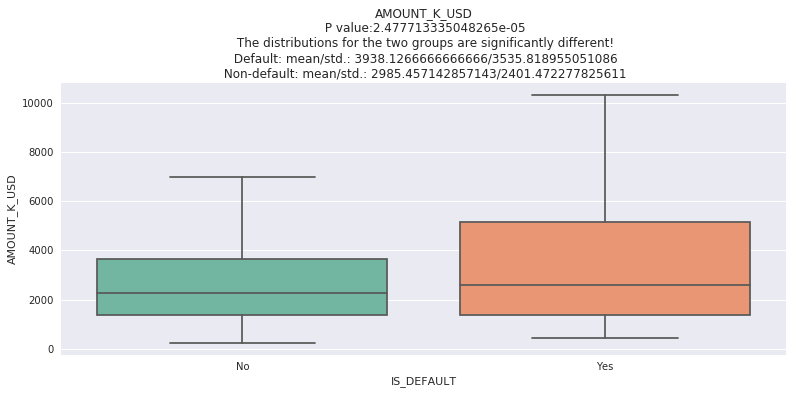

In [12]:
sub_yes = cust_pd[cust_pd["IS_DEFAULT"] == "Yes"]
sub_no = cust_pd[cust_pd["IS_DEFAULT"] == "No"]
    
p_value = ttest_ind(sub_yes['AMOUNT_K_USD'], sub_no["AMOUNT_K_USD"], equal_var = False)[1]

fig, axs = plt.subplots(nrows= 1, figsize=(13, 5))
sns.boxplot(x = "IS_DEFAULT", y = "AMOUNT_K_USD", data = cust_pd, showfliers=False, palette="Set2")
if p_value < .05:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n The distributions for the two groups are significantly different!" + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_no["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))
else:
    plt.title("AMOUNT_K_USD" + "\n P value:" + str(p_value) + "\n Default: mean/std.: " + str(sub_yes["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_yes["AMOUNT_K_USD"].describe()[2]) + "\n Non-default: mean/std.: " + str(sub_safe["AMOUNT_K_USD"].describe()[1]) + "/" + str(sub_no["AMOUNT_K_USD"].describe()[2]))           

In this box plot, the visualization is enhanced by T-test statistics. The result is significant which indicates that the average credit amount for the non-default group and default group are different. Default group has larger average credit amount.



### Default rate by state

In [13]:
default_rate = pd.crosstab(cust_pd.IS_DEFAULT, cust_pd.STATE).apply(lambda r: r/r.sum(), axis=0)

default_rate2 = default_rate.T

%brunel data('default_rate2') map color(Yes) key(STATE) label(STATE)


<IPython.core.display.Javascript object>

Brunel also provides a very neat way for map visualization. So for this use case, all the Merchants come from 4 states: NY, NJ, PA and CT.

### Correlation Matrix

A heatmap is used to visualize the correlations between all continuous variables.

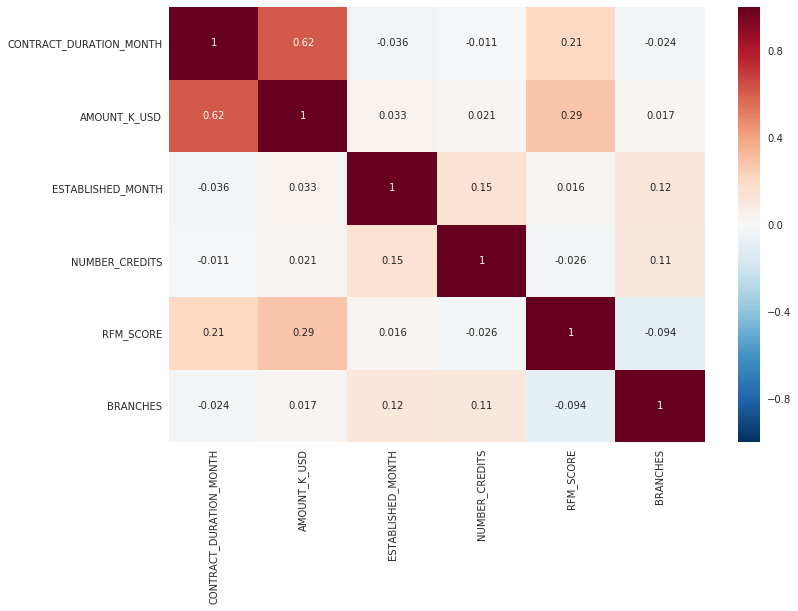

In [14]:
plt.figure(figsize=(12, 8))

corr_df = cust_pd.iloc[:,1:].corr()

sns.heatmap(corr_df, 
            xticklabels = corr_df.columns.values,
            yticklabels = corr_df.columns.values,
            annot = True);


* There is no strong correlation between most variables.
* The correlation between AMOUNT_K_USD and CONTRACT_DURATION_MONTH is moderate.

## Modeling And Evaluation

For demo purpose, we will use RandomForestClassifier() from sklearn to rank feature importance, and Logistic Regression from Spark's Machine Learning Library(MLlib) for modeling.

### Sklearn Random Forest: Rank Feature Importance

In [15]:
# convert IS_DEFAULT to 1/0
le = LabelEncoder()

cust_pd_sk = cust_pd
cust_pd_sk.loc[:,'IS_DEFAULT']= le.fit_transform(cust_pd_sk.loc[:,'IS_DEFAULT'])

y = np.float32(cust_pd_sk.IS_DEFAULT)
X = cust_pd.copy()

# drop y 
X = cust_pd_sk.drop(['IS_DEFAULT', 'MERCHANT'], axis = 1)

# Prepocess the data: Encode categorical variables into numeric representations

categoricalColumns = ["ACCT_STATUS_K_USD", "BRANCHES",'HISTORY', 'CREDIT_PROGRAM', 'ACCOUNT_TYPE', 'ACCT_AGE', 'STATE', 'IS_URBAN', 'IS_XBORDER','SELF_REPORTED_ASMT', 'CO_APPLICANT', 'GUARANTOR','PRESENT_RESIDENT', 'OWN_REAL_ESTATE', 'PROP_UNKN','OTHER_INSTALL_PLAN', 'RENT', 'OWN_RESIDENCE','TELEPHONE', 'SHIP_INTERNATIONAL']

for col in categoricalColumns:
    X[col] = le.fit_transform(X[col])

# scale X
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


random_forest = RandomForestClassifier()

#Stratify split and train on 5 folds
skf = StratifiedKFold(y_train, n_folds=5)
counter = 1
for train_fold, test_fold in skf:
    random_forest.fit(X_train[train_fold], y_train[train_fold])
    
    print( str(counter) + ": ", random_forest.score(X_train[test_fold], y_train[test_fold]))
    counter += 1 
    
#### local notes: one interesting error here, if you don't do the import correctly, it will show error Params must be either a param map or a list/tuple of param maps, but got <class 'pandas.core.series.Series'>.

('1: ', 0.7642857142857142)
('2: ', 0.7142857142857143)
('3: ', 0.7071428571428572)
('4: ', 0.75)
('5: ', 0.6785714285714286)


From the result of 5-fold CV, the average accuracy varies. The model is not very stable, one possible reason is that our sample size is really small. We will need to restrict the model complexity. We will choose top 10 important features for further analysis.

In [16]:
features_order = cust_pd_sk.drop(['IS_DEFAULT', 'MERCHANT'], axis = 1).columns.tolist()

feature_importance_dict = {key: val for key, val in zip(features_order, random_forest.feature_importances_)}

for k in sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True):
    print k, feature_importance_dict[k]

ACCT_STATUS_K_USD 0.13696741128808848
AMOUNT_K_USD 0.13341924478400538
CONTRACT_DURATION_MONTH 0.11371781739069217
ESTABLISHED_MONTH 0.09243576127876028
HISTORY 0.05667046612084905
CREDIT_PROGRAM 0.05290642397967073
ACCOUNT_TYPE 0.0476647897476332
ACCT_AGE 0.04672442762402676
STATE 0.03379163214020585
PRESENT_RESIDENT 0.033489175612302954
RFM_SCORE 0.03311666351988768
NUMBER_CREDITS 0.029717551292003867
SELF_REPORTED_ASMT 0.02288458470685521
TELEPHONE 0.020880567031155886
OTHER_INSTALL_PLAN 0.01864459883659649
IS_URBAN 0.01672416444587057
BRANCHES 0.015967898540582004
PROP_UNKN 0.01494135833497431
IS_XBORDER 0.014796422461262174
OWN_REAL_ESTATE 0.014190670897444265
RENT 0.013292685763777966
OWN_RESIDENCE 0.013156381639841314
CO_APPLICANT 0.010754647481836827
GUARANTOR 0.008687349824833282
SHIP_INTERNATIONAL 0.004457305256843286


### Default Prediction: Spark MLlib Logistic Regression

In this section, We will use Logistic Regression from Spark MLlib to predict defalut.<br/>
We will use the Spark DataFrame for building the Spark ML model

In [17]:
cust_spark.printSchema()

root
 |-- MERCHANT: integer (nullable = true)
 |-- ACCT_STATUS_K_USD: string (nullable = true)
 |-- CONTRACT_DURATION_MONTH: integer (nullable = true)
 |-- HISTORY: string (nullable = true)
 |-- CREDIT_PROGRAM: string (nullable = true)
 |-- AMOUNT_K_USD: integer (nullable = true)
 |-- ACCOUNT_TYPE: string (nullable = true)
 |-- ACCT_AGE: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- IS_URBAN: string (nullable = true)
 |-- IS_XBORDER: string (nullable = true)
 |-- SELF_REPORTED_ASMT: string (nullable = true)
 |-- CO_APPLICANT: string (nullable = true)
 |-- GUARANTOR: string (nullable = true)
 |-- PRESENT_RESIDENT: string (nullable = true)
 |-- OWN_REAL_ESTATE: string (nullable = true)
 |-- PROP_UNKN: string (nullable = true)
 |-- ESTABLISHED_MONTH: integer (nullable = true)
 |-- OTHER_INSTALL_PLAN: string (nullable = true)
 |-- RENT: string (nullable = true)
 |-- OWN_RESIDENCE: string (nullable = true)
 |-- NUMBER_CREDITS: integer (nullable = true)
 |-- RFM_SCORE: i

**Preprocess the data**

In [18]:
# group top 10 features to categorical and numerical
allCols = cust_pd_sk.drop(['MERCHANT','IS_DEFAULT'], 1).columns.tolist()
importantCols = ['AMOUNT_K_USD', 'ACCT_STATUS_K_USD', 'CONTRACT_DURATION_MONTH', 'ESTABLISHED_MONTH', 'HISTORY', 'CREDIT_PROGRAM', 'ACCT_AGE', 'ACCOUNT_TYPE', "PRESENT_RESIDENT", "STATE"]
importantCols_num = ['AMOUNT_K_USD', 'CONTRACT_DURATION_MONTH', 'ESTABLISHED_MONTH']
importantCols_cat = np.setdiff1d(importantCols, importantCols_num).tolist()

In [19]:
# create label_str column
cust_spark1 = cust_spark.withColumnRenamed("IS_DEFAULT", 'label_str')

In [20]:
# One-hot encoder for all categorical varaibles
for categoricalCol in importantCols_cat:
    cust_spark1 = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index").fit(cust_spark1).transform(cust_spark1)
    cust_spark1 = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec").transform(cust_spark1)  

In [21]:
# Assemble feature vector
assemblerInputs = map(lambda c: c + "classVec", importantCols_cat) + importantCols_num
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
cust_spark1 = assembler.transform(cust_spark1)

In [22]:
# Transform the label_str column to a numeric value
cust_spark1 = StringIndexer(inputCol='label_str', outputCol='label').fit(cust_spark1).transform(cust_spark1)

In [23]:
# keep useful variables
selectedcols = ["label", "features"]
cust_model = cust_spark1.select(selectedcols)

** Split the data into training and testing sets **

In [24]:
trainingData, testData = cust_model.randomSplit([0.7, 0.3], seed = 824)
print trainingData.count()
print testData.count()

707
293


**Train Logistic Regression Model**

In [25]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

** Use CrossValidator and ParamGridBuilder to search for best model **

In [26]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [1.0,0.3,0.1, 0.03,0.01,0.0]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(trainingData)

** Use BinaryClassificationEvaluator to evaluate the model**

Note that the default metric for the BinaryClassificationEvaluator is *areaUnderROC*

A rough guide for classifying the accuracy of a test:

    .90-1 = excellent (A)
    .80-.90 = good (B)
    .70-.80 = fair (C)
    .60-.70 = poor (D)
    .50-.60 = fail (F)

So the model performance is fair.

In [27]:
evaluator.evaluate(cvModel.transform(testData))

0.734563681932103

** Final Model**

We will move forward with the model with Top 10 features.

**Hyperparameters used in final model**

In [28]:
print cvModel.bestModel._java_obj.getRegParam()
print cvModel.bestModel._java_obj.getMaxIter()
print cvModel.bestModel._java_obj.getElasticNetParam()
print cvModel.bestModel._java_obj.getThreshold()

0.03
10
0.5
0.5


** Intercept and Weights **

In [29]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [30]:
print "Model Intercept = " + str(cvModel.bestModel.intercept)

coefficients = cvModel.bestModel.coefficients
coefficients = map(lambda w: (float(w),), coefficients)
weightsDF = sqlContext.createDataFrame(coefficients, ["Feature Weight"])
weightsDF.show()

Model Intercept = -0.868522279218
+--------------------+
|      Feature Weight|
+--------------------+
| 0.09615462268269745|
|-0.11352112825447444|
| 0.05356590398944993|
|-0.29414006757842653|
|                 0.0|
|                 0.0|
| -0.3755837200169418|
| 0.03834058518611635|
| -0.9852342832251151|
| 0.49566506243563946|
|                -0.0|
|-0.22637462732139962|
|  0.3961194344863037|
|-0.02300263596259...|
| -0.7408629365037356|
|                 0.0|
|                 0.0|
|                 0.0|
| -0.5769982006030716|
|                 0.0|
+--------------------+
only showing top 20 rows



## Create Pipeline for ML

In [31]:
trainingData3, testData3 = cust_spark.randomSplit([0.7, 0.3], seed = 824)

SI0 = StringIndexer(inputCol='IS_DEFAULT', outputCol="label")
SI1 = StringIndexer(inputCol='ACCOUNT_TYPE', outputCol='ACCOUNT_TYPE'+"Index")
SI2 = StringIndexer(inputCol='ACCT_AGE', outputCol='ACCT_AGE'+"Index")
SI3 = StringIndexer(inputCol='ACCT_STATUS_K_USD', outputCol='ACCT_STATUS_K_USD'+"Index")
SI4 = StringIndexer(inputCol='CREDIT_PROGRAM', outputCol='CREDIT_PROGRAM'+"Index")
SI5 = StringIndexer(inputCol='HISTORY', outputCol='HISTORY'+"Index")
SI6 = StringIndexer(inputCol='PRESENT_RESIDENT', outputCol='PRESENT_RESIDENT'+"Index")
SI7 = StringIndexer(inputCol='STATE', outputCol='STATE'+"Index")


OH1 = OneHotEncoder(inputCol='ACCOUNT_TYPE'+"Index", outputCol='ACCOUNT_TYPE'+"classVec")
OH2 = OneHotEncoder(inputCol='ACCT_AGE'+"Index", outputCol='ACCT_AGE'+"classVec")
OH3 = OneHotEncoder(inputCol='ACCT_STATUS_K_USD'+"Index", outputCol='ACCT_STATUS_K_USD'+"classVec")
OH4 = OneHotEncoder(inputCol='CREDIT_PROGRAM'+"Index", outputCol='CREDIT_PROGRAM'+"classVec")
OH5 = OneHotEncoder(inputCol='HISTORY'+"Index", outputCol='HISTORY'+"classVec")
OH6 = OneHotEncoder(inputCol='PRESENT_RESIDENT'+"Index", outputCol='PRESENT_RESIDENT'+"classVec")
OH7 = OneHotEncoder(inputCol='STATE'+"Index", outputCol='STATE'+"classVec")

assembler_features = VectorAssembler(inputCols=['ACCOUNT_TYPEclassVec','ACCT_AGEclassVec','ACCT_STATUS_K_USDclassVec','CREDIT_PROGRAMclassVec','HISTORYclassVec','PRESENT_RESIDENTclassVec', 'STATEclassVec',
 'AMOUNT_K_USD',
 'CONTRACT_DURATION_MONTH',
 'ESTABLISHED_MONTH'], outputCol="features")

lr_final = LogisticRegression(maxIter=10, regParam=0.1, elasticNetParam=0.0, threshold = 0.5, labelCol="label", featuresCol="features")

pipeline_lr = Pipeline(stages=[SI0,SI1, SI2, SI3,SI4,SI5,SI6,SI7, OH1,OH2,OH3,OH4,OH5,OH6,OH7, assembler_features, lr_final])
model_lr = pipeline_lr.fit(trainingData3)

## Save Model in ML repository


In [33]:
from dsx_ml.ml import save

model_name = "CreditCardDefault_model"
save(name = model_name,
     model = model_lr,
     algorithm_type = 'Classification',
     test_data = testData3)

{'path': '/user-home/1006/DSX_Projects/DSX_Demos_Test/models/CreditCardDefault_model/3',
 'scoring_endpoint': 'https://dsxl-api/v3/project/score/Python27/spark-2.0/DSX_Demos_Test/CreditCardDefault_model/3'}

### Test Saved Model with Test UI

This step demonstrates an "internal REST API" call to test the model (for an unpublished model). Notice that we are using DSX variables for the model endpoint and token. See documentation for external REST call syntax. An exernal REST call will have a different end point and will require authentication. 

In [34]:
json_payload =[{
    "MERCHANT":999,
    "ACCT_STATUS_K_USD":"0 USD",
    "CONTRACT_DURATION_MONTH":12,
    "HISTORY":"CRITICAL ACCOUNT",
    "CREDIT_PROGRAM":"NEW CAR",
    "AMOUNT_K_USD":2171,
    "ACCOUNT_TYPE":"up to 100 K USD",
    "ACCT_AGE":"1 to 4 YRS",
    "STATE":"NY",
    "IS_URBAN":"NO",
    "IS_XBORDER":"NO",
    "SELF_REPORTED_ASMT":"NO",
    "CO_APPLICANT":"YES",
    "GUARANTOR":"NO",
    "PRESENT_RESIDENT":"4",
    "OWN_REAL_ESTATE":"NO",
    "PROP_UNKN":"NO",
    "ESTABLISHED_MONTH":38,
    "OTHER_INSTALL_PLAN":"NO",
    "RENT":"NO",
    "OWN_RESIDENCE":"YES",
    "NUMBER_CREDITS":2,
    "RFM_SCORE":2,
    "BRANCHES":1,
    "TELEPHONE":"YES",
    "SHIP_INTERNATIONAL":"NO"}]

**Action Required**: Change the *scoring_endpoint* to the value that's shown as the *scoring_endpoint* afer running Save to ML repository function (see **Step 9**), for example *'scoring_endpoint': 'https://ibm-nginx-svc.ibm-private-cloud.svc.cluster.local/v3/project/score/Python27/spark-2.0/DSX_Local_Workshop_SidneyP/CreditCardDefault_model/1'*. 

In [35]:
import requests, json, os
from pprint import pprint

online_path = 'https://dsxl-api/v3/project/score/Python27/spark-2.0/DSX_Demos_Test/CreditCardDefault_model/2'

header_online = {'Content-Type': 'application/json', 'Authorization':os.environ['DSX_TOKEN']}

response_scoring = requests.post(online_path, json=json_payload, headers=header_online)

response_scoring.text

u'{"success":true,"description":"Success","object":{"error":"","output":{"classes":[0,1],"predictions":[0],"probabilities":[[0.5933043094696558,0.4066956905303441]]},"returnCode":"0"}}'

In [36]:
prediction = response_scoring.json()['object']['output']['predictions'][0]
print ('Prediction = {}'.format(prediction))
probabilities = response_scoring.json()['object']['output']['probabilities'][0]
print ('Probabilities = {}'.format(probabilities))
if prediction == 0:
    print('Prediction = No')
    print('Probability = {0:.2f}'.format(probabilities[0]*100))
elif prediction == 1:
    print('Prediction = Yes')
    print('Probability = {0:.2f}%'.format(probabilities[1]*100))
else:
    print('Probability ERROR')

Prediction = 0
Probabilities = [0.5933043094696558, 0.4066956905303441]
Prediction = No
Probability = 59.33


## Summary

You have finished working on this hands-on lab. In this notebook you have:
1. Use Brunel and Seaborn library for visualizations

2. Use regular python Machine Learning libary scikit-learn to build a RandomForestClassifier, and extracted the top 10 most important predictors
3. Use Spark's Machine Learning library(MLlib) to build a LogisticRegression model with the top 10 most important predictors.
4. Deploy SparkML model using Machine Learning Service


Created by **Catherine Cao** and **Sidney Phoon**
<br/>
catherine.cao@ibm.com<br/>
yfphoon@us.ibm.com<br/>

Feb 12, 2018